In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar

np.random.seed(20180606)

In [116]:
# Defining The Kalman Filter Class

class KalmanFilter:
    def __init__(self, A, B, Q, H, R):
        # 초기화
        self.A = A
        self.B = B
        self.Q = Q
        self.H = H
        self.R = R
    
    def Predict(self, inputs):
        x, P = inputs
        x_pred = np.dot(self.A,x)
        P_pred = np.dot(np.dot(self.A,P),self.A.T) + self.Q
        z_pred = np.dot(self.H, x_pred)
        return x_pred, P_pred, z_pred

    def Update(self, update, z_meas):
        x_pred, P_pred, z_pred = update
        v = z_meas - z_pred
        F = np.dot(np.dot(self.H, P_pred),self.H.T) + self.R
        K = np.dot(np.dot(P_pred, self.H.T), linalg.inv(F))
        x_update = x_pred + np.dot(K, v)
        P_update = P_pred - np.dot(np.dot(K, self.H), P_pred)
        dF = max(linalg.det(F),10e-10)
        logl = (-0.5*np.log(2*np.pi) - 0.5*np.log(dF) - 0.5*np.dot(np.dot(v.T, linalg.inv(F)),v))[0][0]
        return x_update, P_update, logl
    
    def __Next(self, x0):
        m = self.Q.shape[0]
        l = self.R.shape[0]
        x = np.dot(self.A,x0)+self.B + np.random.multivariate_normal(mean=np.zeros(m), cov=self.Q).reshape(m,1)
        z = np.dot(H,x) + np.random.multivariate_normal(mean=np.zeros(l), cov=self.R).reshape(l,1)
        return x, z
    
    def Generate(self, x, n=1):
        for i in range(n):
            if i == 0:
                xstack, zstack = self.__Next(x)
                x = xstack
                continue
            x, z = self.__Next(x)
            xstack = np.concatenate((xstack, x), axis=1)
            zstack = np.concatenate((zstack, z), axis=1)
        return xstack, zstack

In [154]:
# Objective Function

def ObjectiveKF(a, dt, x0, P0, z):
    
    # 입력변수들을 State-Measurement 방정식에 입력
    A = np.array([[a, dt],
                  [0, a]])
    B = np.array([[dt**2/2],
                  [dt]])
    Q = np.identity(2)
    H = np.array([[1,0]])
    R = np.array([[10]])
    
    # Kalman Filter 객체 생성
    kf = KalmanFilter(A,B,Q,H,R)
    
    # 초기값 입력
    xf, Pf = x0, P0
    
    # 필터링 및 Log-likelihood 스택 쌓기
    loglstack = []
    for k in [z[:,i] for i in range(z.shape[1])]:
        xf, Pf, logl = kf.Update(kf.Predict([xf,Pf]), k)
        loglstack.append(logl)
        
    # The total sum of log-likelihood
    return sum(loglstack)

In [155]:
# Actual System

dt = 0.1
A = np.array([[1, dt],
              [0, 1]])
B = np.array([[dt**2/2],
              [dt]])
Q = np.identity(2)
H = np.array([[1,0]])
R = np.array([[10]])

In [156]:
# Generate Actual State and Measurement

xi = np.array([[1],
               [0]])

kf = KalmanFilter(A,B,Q,H,R)
x, z = kf.Generate(x=xi, n=2000)

In [157]:
# Input Initial State 

x0 = np.array([[1],
               [0]])
P0 = np.array([[0.1, 0],
               [0, 0.1]])

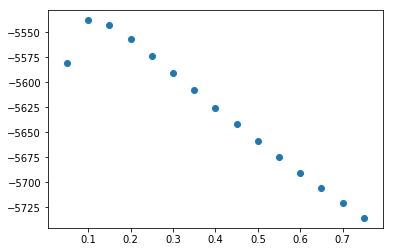

In [158]:
# Objective Function along dt

t = np.arange(0.05,0.80,0.05)
y = list(map(lambda x:ObjectiveKF(a=1, dt=x, x0=x0,P0=P0,z=z), t))
plt.scatter(t,y)
plt.show()

In [159]:
# Optimization

res = minimize_scalar(lambda x:-ObjectiveKF(a=1, dt=x, x0=x0,P0=P0,z=z), method='bounded', bounds=(0,1))
print('Optimized at dt = {:.2f}'.format(res.x))

Optimized at dt = 0.11


In [160]:
# Optimization multi-variables
p = np.array([2, 0.2])
res = minimize(lambda x:-ObjectiveKF(a=x[0], dt=x[1], x0=x0,P0=P0,z=z), p, method='nelder-mead', options={'xtol':1e-8})
print('Optimized at  a = {:.3f} and dt = {:.3f}'.format(res.x[0], res.x[1]))

Optimized at  a = 1.000 and dt = 0.094


In [161]:
# Filtering

p = res.x[0]
dt = res.x[1]

A = np.array([[p, dt],
              [0, p]])
B = np.array([[dt**2/2],
              [dt]])
Q = np.identity(2)
H = np.array([[1,0]])
R = np.array([[100]])


kf = KalmanFilter(A,B,Q,H,R)
xf, Pf = x0, P0
xstack = xf
loglstack = []
for k in [z[:,i] for i in range(z.shape[1])]:
    xf, Pf, _ = kf.Update(kf.Predict([xf,Pf]), k)
    xstack = np.concatenate((xstack, xf), axis=1)

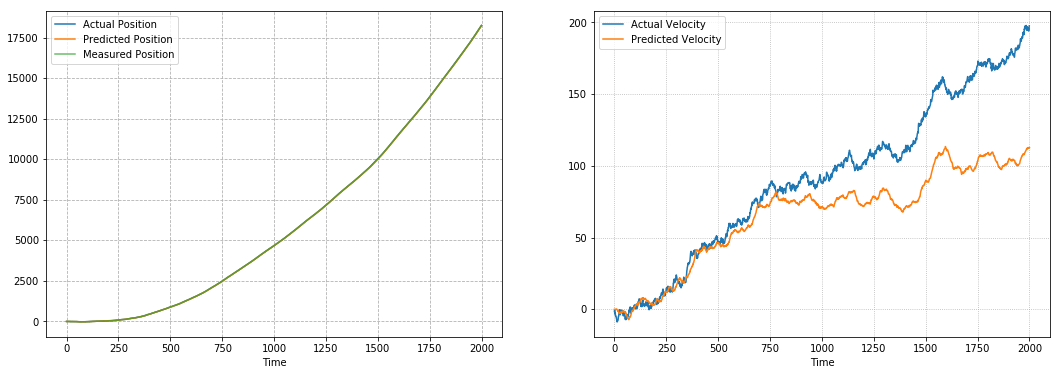

In [162]:
# Graph

fig, ax = plt.subplots(1,2, figsize=(18,6), sharex=True)

ax[0].plot(x[0,:], label='Actual Position')
ax[0].plot(xstack[0,:], label='Predicted Position')
ax[0].plot(z[0,:], label='Measured Position', alpha=0.7)
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].grid(True, linestyle='--')

ax[1].plot(x[1,:], label='Actual Velocity')
ax[1].plot(xstack[1,:], label='Predicted Velocity')
ax[1].legend()
ax[1].set_xlabel('Time')
ax[1].grid(True, linestyle=':')

plt.show()